In [29]:
import os
import pandas as pd
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
#from Bio import SeqIO
#from Bio import AlignIO   #, Align
#import shutil
#from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')

In [15]:
#Plot Nielsen Lab Selection Calculations vs orthogroup conservation

#Load main analysis file
#struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Filter_clusters.pkl'), 'rb'))
struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Analysis_new_02.pkl'), 'rb'))

params_to_plot = ['Mean(Mapping rate)', 'Mean(Conservation rate AA)', 'Mean(Conservation rate Type)']

struct_data_to_plot = {}

for jj, (og_ref, struct_data) in enumerate(struct_analysis.items()): 
    og = og_ref.split('_')[0]
    struct_data_og = []
    for param in params_to_plot:
        struct_data_og.append(struct_data[param])
    struct_data_to_plot[jj] = [og] + struct_data_og 
    
struct_data_to_plot_df = pd.DataFrame.from_dict(struct_data_to_plot, orient='index', columns = ['og'] + params_to_plot )

#Load Nielsen Lab files 

dnds_nl_with_SCE = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_OG_with_SCE.csv'), index_col=0)
dnds_nl_with_SCE['og'] = [og_label.split('.')[0] for og_label in dnds_nl_with_SCE['OG']]


dnds_nl_03_02 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_03_02.csv'), index_col=0)
dnds_nl_03_02['og'] =  [og_label.split('.')[0] for og_label in dnds_nl_03_02['OG']]

# G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\from_nielsen_lab
#     gene_dn_ds_OG_with_SCE.csv
#     gene_dn_ds_03_02.csv

struct_data_to_plot_df = struct_data_to_plot_df.merge(dnds_nl_with_SCE, how='left', on='og')
struct_data_to_plot_df.rename(columns= {'dN_dS': 'dN_dS_SCE'}, inplace=True)

struct_data_to_plot_df = struct_data_to_plot_df.merge(dnds_nl_03_02,  suffixes = ("_SCE", "_nl_02_03"), how='left', on='og')
struct_data_to_plot_df.rename(columns= {'dN_dS': 'dN_dS_nl_02_03'}, inplace=True)

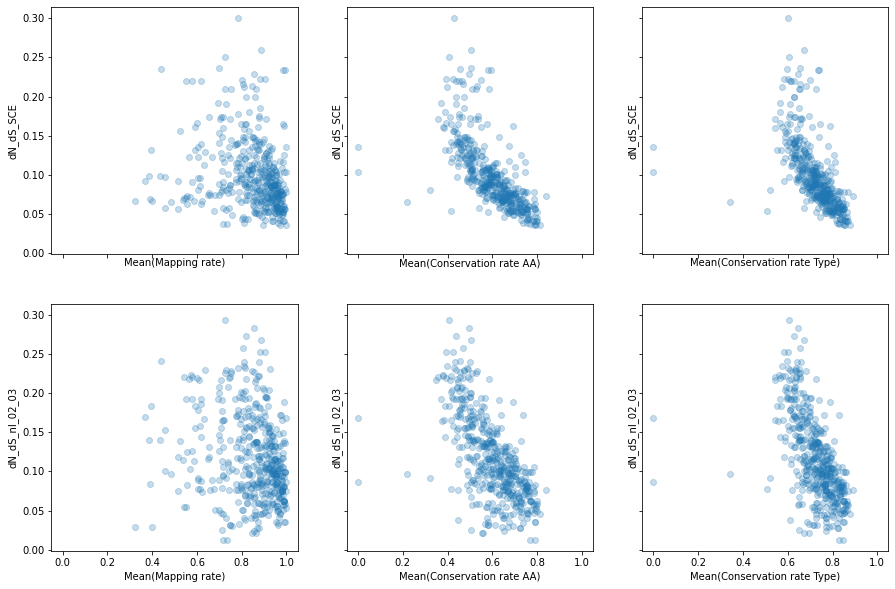

In [16]:
fig, axarr = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey = True)
dnds_cols = [ 'dN_dS_SCE', 'dN_dS_nl_02_03']

for jj, dnds_col in enumerate(dnds_cols):
    for kk, param_to_plot in enumerate(params_to_plot):
        ax = axarr[jj][kk]
        ax.scatter(struct_data_to_plot_df[param_to_plot], struct_data_to_plot_df[dnds_col], alpha = 0.25)
        ax.set_ylabel(dnds_col)
        ax.set_xlabel(param_to_plot)



In [17]:
struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']<0.15)]

,og,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
0,OG4352,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860
16,OG5441,0.853605,0.495190,0.639921,OG5441.out_yn00,0.1255,OG5441.out_yn00,0.16480
71,OG2678,0.814576,0.483090,0.635852,OG2678.out_yn00,0.1197,OG2678.out_yn00,0.19180
76,OG1714,0.676485,0.416213,0.507707,OG1714.out_yn00,0.0538,OG1714.out_yn00,0.07710
77,OG4379,0.814037,0.456149,0.632942,OG4379.out_yn00,0.1210,OG4379.out_yn00,0.16950
80,OG1564,0.722593,0.413850,0.578636,OG1564.out_yn00,0.1166,OG1564.out_yn00,0.16610
159,OG2182,0.629791,0.475567,0.620852,OG2182.out_yn00,0.1132,OG2182.out_yn00,0.16665
175,OG1640,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035
178,OG2567,0.831400,0.458545,0.600424,OG2567.out_yn00,0.1319,OG2567.out_yn00,0.19380
179,OG2382,0.741004,0.467911,0.634800,OG2382.out_yn00,0.1352,OG2382.out_yn00,0.21970


In [18]:
struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']>0.20)]

,og,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
64,OG4150,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826
276,OG4552,0.440031,0.455022,0.598244,OG4552.out_yn00,0.2350,OG4552.out_yn00,0.2412
292,OG4021,0.723453,0.407698,0.605029,OG4021.out_yn00,0.2506,OG4021.out_yn00,0.2928
338,OG1273,0.810761,0.396297,0.574302,OG1273.out_yn00,0.2126,OG1273.out_yn00,0.2346
405,OG2603,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577
409,OG1630,0.782234,0.428489,0.599888,OG1630.out_yn00,0.2997,OG1630.out_yn00,0.2319
482,OG1807,0.882005,0.424185,0.600026,OG1807.out_yn00,0.2227,OG1807.out_yn00,0.2524
490,OG3811,0.580031,0.435539,0.608048,OG3811.out_yn00,0.2201,OG3811.out_yn00,0.1927
504,OG3811,0.550380,0.450656,0.612648,OG3811.out_yn00,0.2201,OG3811.out_yn00,0.1927
506,OG1807,0.905620,0.392888,0.581863,OG1807.out_yn00,0.2227,OG1807.out_yn00,0.2524


,og,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
13,OG1299,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723
64,OG4150,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826
374,OG2845,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,0.1342
388,OG3677,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,0.1178
405,OG2603,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577
413,OG1299,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723


Used Singularity Environment to prepare alignments 
    diverse_yeast/20221206_struct_align_dnds_preps.sh

Used Singularity Environment to generate yn00 files
    diverse_yeast/20221207_run_yn00.sh

In [33]:
#Parse YN00 files 
#Based on https://github.com/SysBioChalmers/Multi_scale_evolution/blob/main/evolution_analysis/code/gene_dn_ds_paml/result_parse_yn00_update.py
def calMean_dN_dS(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS", min_ds = 0.005, max_ds = 3.0, max_dn_ds = 50):

    # for the test
    # paml_gene_dn_ds_file = "/media/luhongzhong/newdisk/Genomics_data/result_paml/YAL015C.out_yn00"
    # output_dir = "/media/luhongzhong/newdisk/Genomics_data/result_paml/YAL015C_yn00.csv"

    result_file = open(paml_gene_dn_ds_file).readlines()
    index0 = [i for i, x in enumerate(result_file) if "seq. seq." in x]
    index1 = [i for i, x in enumerate(result_file) if "(C) LWL85, LPB93 & LWLm methods" in x]
    dn_ds = result_file[index0[0]:index1[0]]
    # further remove the line with only "\n"
    dn_ds0 = [x for x in dn_ds if x != "\n"]
    # save the dn_ds
    dn_ds_df = Export_dn_ds(dnds1=dn_ds0, output_file=output_file)
    
    #Filter dS to be between 0.005 and less than 3
    dn_ds_filt1 = dn_ds_df[(dn_ds_df['dS_new']>min_ds)&(dn_ds_df['dS_new']<max_ds)]

    #Filter Omega greater than 50 
    #Original code had this comment:
    #       here should we filter out omega > 50
    #       here it may be not reasonable to filter out omega > 50. In fact, these value should be zero
    # I presume the DS filter gets rid of those, i will raise a warning if this filter is used
    dn_ds_filt2 = dn_ds_filt1[dn_ds_filt1['omega_new']<max_dn_ds]
    if len(dn_ds_filt2)<len(dn_ds_filt1): 
        warnings.warn('Omega greater than ' + str(max_dn_ds) + ' in ' + maml_gene_dn_ds_file)

    ds = dn_ds_filt2['dS_new']
    dn = dn_ds_filt2['dN_new']
    dn_ds = dn_ds_filt2['omega_new']
    
    
    if method == "mean":
        average_dn_ds = np.mean(dn_ds[np.isfinite(dn_ds)])
        return average_dn_ds
    elif method == "median":
        median_dn_ds = np.median(dn_ds[np.isfinite(dn_ds)])
        return median_dn_ds
    elif method == "max":
        max_dn_ds = np.nanmax(dn_ds)
        return max_dn_ds
    elif method == "median dN_dS, dN, dS":
        return (np.median(dn_ds[np.isfinite(dn_ds)]),np.median(dn[np.isfinite(dn)]),np.median(ds[np.isfinite(ds)]) )
    
    

    
    
    
#     dS0= dn_ds_df["dS_new"].tolist()
    
#     omega0 = dn_ds_df["omega_new"].tolist()
#     # new filter added for the dN_dS calculation
#     omega_filter = []
#     for x,y in zip(dS0,omega0):
#         if x >=0.005 and x <=3:
#             omega_filter.append(y)
#         else: pass
#     new = np.array(omega_filter)
#     # here should we filter out omega > 50
#     # here it may be not reasonable to filter out omega > 50. In fact, these value should be zero
#     new = new[new < 50]
#     # new[new > 50] = 0
#     median_dn_ds = np.median(new[np.isfinite(new)])
#     average_dn_ds = np.mean(new[np.isfinite(new)])
#     max_dn_ds = np.nanmax(new)
#     if method == "mean":
#         return average_dn_ds
#     elif method == "median":
#         return median_dn_ds
#     elif method == "max":
#         return max_dn_ds

    
def Export_dn_ds(dnds1, output_file):
    new_dnds = []
    colname1 = None
    for i, x in enumerate(dnds1):
        if i == 0:
            colname = x.split("  ")
            colname0 = [n.strip(" ").strip("\n") for n in colname if n != ""]
            c1 = ["seq1", "seq2"]
            colname1 = c1 + colname0[1:]
        else:
            x1 = x.split(" ")
            x1 = [n.strip(" ").strip("\n") for n in x1 if n != ""]
            n1 = " ".join(x1[10:])
            n2 = " ".join(x1[7:10])
            x1_new = x1[0:7] + [n2] + [n1]
            x2 = "@".join(x1_new)
            new_dnds.append(x2)
    df = pd.DataFrame({"ID": new_dnds})
    df1 = df['ID'].str.split('@', expand=True)
    df1.columns = colname1

    dS0 = df1["dS +- SE"].tolist()
    dS1 = [float(x.split("+-")[0]) for x in dS0]
    dN0 = df1["dN +- SE"].tolist()
    dN1 = [float(x.split("+-")[0]) for x in dN0]
    omega0 = df1["omega"].tolist()
    omega1 = [float(x) for x in omega0]
    

    df1["dS_new"] = dS1
    df1["dN_new"] = dN1
    df1["omega_new"] = omega1

    df1.to_csv(output_file)
    return df1

In [34]:
og_ref_base = selected_og_refs[0]
yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref_base) + os.sep
output_file = yn00_dir + 'yn00.csv'
paml_gene_dn_ds_file = yn00_dir +  'yn00.out'

(dn_ds, dn, ds) = calMean_dN_dS(paml_gene_dn_ds_file, output_file)


In [41]:
dN_dS_struct

[0.2764, 0.2975, 0.1672, 0.1337, 0.1063]

In [46]:
#Pick OGs that have higher dN/dS
#4150, 2603, 
#and lower: 
#3677, 2845 
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs_dict = {og_ref.split('_REF_')[0]:og_ref for og_ref in selected_og_refs}
struct_data_dnds_ex = struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs_dict.keys())].copy()

dN_dS_struct = []
dN_struct = []
dS_struct = []

for og in struct_data_dnds_ex['og']:
    og_ref_base = selected_ogs_dict[og]
    yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref_base) + os.sep
    output_file = yn00_dir + 'yn00.csv'
    paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
    (dN_dS, dN, dS) = calMean_dN_dS(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS")
    dN_dS_struct.append(dN_dS)
    dN_struct.append(dN)
    dS_struct.append(dS)

struct_data_dnds_ex['dN_dS_struct']= dN_dS_struct
struct_data_dnds_ex['dN_struct']= dN_struct
struct_data_dnds_ex['dS_struct']= dS_struct


In [47]:
struct_data_dnds_ex

,og,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct
13,OG1299,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723,0.1063,0.15790,1.49275
64,OG4150,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826,0.2764,0.54320,1.81100
374,OG2845,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,0.1342,0.1672,0.34990,2.31910
388,OG3677,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,0.1178,0.1337,0.36390,2.56720
405,OG2603,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577,0.2975,0.65965,2.11475
413,OG1299,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723,0.1063,0.15790,1.49275


In [ ]:
# Make Codon Based Structural Alignments from Nir's 

#Make Codon Based structural Alignments
#Also make a mapping from the index in the struct data file to the sequence name in order to shorten filenames for CodeML

#For an orthogroup/reference
og_seq_dir = base_dir + os.sep + "og_sequences"

og_pep_dir = og_seq_dir + os.sep + 'proteome' 

#Loop through all structures in that directory
for og_pep_fname in os.listdir(og_pep_dir):
    #og_pep_fname =  'OG1299_REF_Scer_AF-P00549-F1-model_v2.pep.fasta'

    og_ref_base = og_pep_fname.split('.')[0]

    og,ref = og_ref_base.split('_REF_')



    #Load structural alignment

    struct_data_fname = base_dir + os.sep + os.path.normpath('Output/Summary/REF_' + ref + '.pkl')
    struct_aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/fasta_filt_cds/' + og_ref_base + '.struct_filt_cds.fasta')

    og_struct_data = pickle.load(open(struct_data_fname, 'rb'))

    #Extract Protein sequences and build dictionary
    pep_dict = {} 
    pep_fasta = SeqIO.parse(og_pep_dir + os.sep + og_pep_fname, 'fasta')
    for record in pep_fasta:
        pep_dict[record.id] = record.seq

    #Extract Codon Sequences and build dictionary
    cds_dict = {} 
    cds_fasta = SeqIO.parse(og_seq_dir + os.sep + 'cds' + os.sep + og_ref_base + '.cds.fasta', 'fasta')
    for record in cds_fasta:
        cds_dict[record.id] = record.seq


    seq_name_map = {}
    seq_name_map_fname = og_seq_dir + os.sep + 'seq_name_map' + os.sep + og_ref_base + '.tsv'



    with open(struct_aln_cds_fname, 'w') as fout_struct_cds: 
        for seq_ind, name in enumerate(og_struct_data['Molecules'].keys()): 

            seq_name_map[name] = og + '_' + str(seq_ind)

            #seq_pep = pep_dict[name]
            seq_cds = str(cds_dict[name])

            #Extract trimming data
            seq_mapping = og_struct_data['Mapping']['Mapping'][seq_ind]



            line_header = '>' + name + '\n'

            #aa_line = ''
            codon_line = ''
            for aln_ind in seq_mapping: 
                if aln_ind ==-1: 
                    #aa_line = aa_line + '-'
                    codon_line = codon_line + '---'
                else: 
                    #aa_line = aa_line + seq_aa[aln_ind]
                    codon_line = codon_line + seq_cds[3*aln_ind: 3*aln_ind + 3]

            #assert aa_line==struct_aln_aa_dict[seq_aln_id], seq_aln_id + ' msa in filtered structure alignments does not have same alignment as corresponding sequence, ' + name + ', in raw data'

            fout_struct_cds.write(line_header)
            fout_struct_cds.write(codon_line + '\n')


    seq_name_map_ser = pd.Series(seq_name_map, name = 'seq_no')
    seq_name_map_ser.index.name = 'seq_name'
    seq_name_map_ser.to_csv(seq_name_map_fname, sep='\t')



In [9]:
og_base = 'OG4150_REF_Scer_AF-P07256-F1-model_v2'
seq_name_map_fname = base_dir + os.sep +  os.path.normpath('msas/structural/tm_align/seq_name_map/' + og_base + '.tm.tsv')
seq_name_map_df = pd.read_csv(seq_name_map_fname, sep='\t', index_col=None)
seq_name_map = dict(zip(seq_name_map_df['seq_name'],seq_name_map_df['seq_no']))

In [ ]:
#Get structural tree using MSA from Nir
#Convert tree to required format
#Run CodeML with yn00 parameters

In [ ]:
#REad in yn00 data

In [ ]:
## Output data:  csv with og_ref filenames and yn00 outputs